In [1]:

import os
import re
import glob
import xarray as xr


In [2]:

def merge_netcdf_groups(output_dir):
    # Pattern to match files with 8-digit date stamp followed by underscore and anything ending with .nc
    pattern = re.compile(r"^(\d{8})_.*\.nc$")
    
    # Find all matching .nc files in the output directory
    all_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if pattern.match(f)]
    
    # Group files by their date stamp
    groups = {}
    for filepath in all_files:
        filename = os.path.basename(filepath)
        m = pattern.match(filename)
        if m:
            date_stamp = m.group(1)
            groups.setdefault(date_stamp, []).append(filepath)
    
    # Process each group
    for date_stamp, file_list in groups.items():
        if not file_list:
            continue
        
        print(f"Merging {len(file_list)} files for date {date_stamp}...")
        try:
            files = []
            for f in file_list:
                files.append(xr.open_dataset(f))
            
            # Open and merge files; adjust the combine option if needed based on file structure.
            ds = xr.merge(files)
            output_file = os.path.join(output_dir, f"{date_stamp}_daily_output.nc")
            ds.to_netcdf(output_file)
            ds.close()
            print(f"Created merged file: {output_file}")
            
            # # After successful merge, delete the individual files
            # for f in file_list:
            #     os.remove(f)
            #     print(f"Deleted file: {f}")
        except Exception as e:
            print(f"Error merging files for date {date_stamp}: {e}")


In [5]:

if __name__ == "__main__":
    # Set your output directory here
    output_directory = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output"
    merge_netcdf_groups(output_directory)


Merging 75 files for date 20250127...
Created merged file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250127_daily_output.nc
Merging 75 files for date 20250210...
Created merged file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250210_daily_output.nc
Merging 75 files for date 20250224...
Created merged file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250224_daily_output.nc


In [9]:

import os
import glob
import shutil
import numpy as np
import xarray as xr

def update_yearly_master_files(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Pattern to match files like YYYYMMDD_daily_output.nc
    pattern = os.path.join(input_dir, "*_daily_output.nc")
    daily_files = glob.glob(pattern)
    
    for file in daily_files:
        print(f"Processing file: {file}")
        try:
            ds = xr.open_dataset(file)
        except Exception as e:
            print(f"Error opening {file}: {e}")
            continue

        # Determine the unique years present in the dataset’s time coordinate.
        unique_years = np.unique(ds['time'].dt.year.values)
        
        for yr in unique_years:
            ds_year = ds.sel(time=ds['time'].dt.year == yr)
            master_filename = os.path.join(output_dir, f"{yr}_daily_output.nc")
            
            if os.path.exists(master_filename):
                # Create a backup of the existing master file.
                backup_filename = master_filename + ".bak"
                try:
                    shutil.copy(master_filename, backup_filename)
                    print(f"Backup created: {backup_filename}")
                except Exception as e:
                    print(f"Error creating backup for {master_filename}: {e}")
                    continue

                try:
                    master_ds = xr.open_dataset(master_filename)
                except Exception as e:
                    print(f"Error opening {master_filename}: {e}")
                    continue

                try:
                    # Concatenate along the time dimension and remove duplicate times
                    combined_ds = xr.concat([master_ds, ds_year], dim="time")
                    combined_ds = combined_ds.sortby("time")
                    times = combined_ds['time'].values
                    _, index = np.unique(times, return_index=True)
                    combined_ds = combined_ds.isel(time=index)
                    master_ds.close()
                    combined_ds.to_netcdf(master_filename)
                    print(f"Updated master file for {yr}: {master_filename}")
                except Exception as e:
                    print(f"Error updating {master_filename}: {e}")
                    continue
            else:
                try:
                    ds_year = ds_year.sortby("time")
                    ds_year.to_netcdf(master_filename)
                    print(f"Created new master file for {yr}: {master_filename}")
                except Exception as e:
                    print(f"Error creating master file {master_filename}: {e}")
        
        ds.close()



In [10]:

if __name__ == "__main__":
    # Set the directories where your daily output files are located and where you want the master files.
    input_directory = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output"      # adjust as needed
    output_directory = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output"     # adjust as needed
    update_yearly_master_files(input_directory, output_directory)


Processing file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250127_daily_output.nc
Created new master file for 2023: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2023_daily_output.nc
Created new master file for 2024: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2024_daily_output.nc
Created new master file for 2025: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2025_daily_output.nc
Processing file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250210_daily_output.nc
Backup created: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2024_daily_output.nc.bak
Updated master file for 2024: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2024_daily_output.nc
Backup created: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2025_daily_output.nc.bak
Updated master file for 2025: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2025_daily_output.nc
Processing file: ../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/2

In [11]:
ds = xr.open_dataset("../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2023_daily_output.nc")
ds

<xarray.Dataset> Size: 394MB
Dimensions:              (time: 365, hruid: 3851, segid: 1942)
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * hruid                (hruid) int32 15kB 83028 83029 83030 ... 86905 86906
  * segid                (segid) int32 8kB 42706 42707 42708 ... 44661 44662
Data variables: (12/79)
    hru_lat              (hruid) float64 31kB ...
    hru_lon              (hruid) float64 31kB ...
    pk_precip            (time, hruid) float32 6MB ...
    dprst_area_open      (time, hruid) float32 6MB ...
    snow_evap            (time, hruid) float32 6MB ...
    snowcov_area         (time, hruid) float32 6MB ...
    ...                   ...
    seg_outflow          (time, segid) float32 3MB ...
    tminf                (time, hruid) float32 6MB ...
    hru_sroffi           (time, hruid) float32 6MB ...
    seg_shade            (time, segid) float32 3MB ...
    hru_rain             (time, hruid) float32 6MB ...
    dprst_vol_open       (time, hruid) float32 6MB ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:      2025-01-29T13:28:16.428346
    source:       pyonhm: pyonhm/out2ncf/out2ncf.py

In [12]:
ds = xr.open_dataset("../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2024_daily_output.nc")
ds

<xarray.Dataset> Size: 429MB
Dimensions:              (time: 366, hruid: 3851, segid: 1942)
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2024-01-01 ... 2024-12-31
  * hruid                (hruid) int32 15kB 83028 83029 83030 ... 86905 86906
  * segid                (segid) int32 8kB 42706 42707 42708 ... 44661 44662
Data variables: (12/79)
    hru_lat              (time, hruid) float64 11MB ...
    hru_lon              (time, hruid) float64 11MB ...
    pk_precip            (time, hruid) float32 6MB ...
    dprst_area_open      (time, hruid) float32 6MB ...
    snow_evap            (time, hruid) float32 6MB ...
    snowcov_area         (time, hruid) float32 6MB ...
    ...                   ...
    seg_outflow          (time, segid) float32 3MB ...
    tminf                (time, hruid) float32 6MB ...
    hru_sroffi           (time, hruid) float32 6MB ...
    seg_shade            (time, segid) float32 3MB ...
    hru_rain             (time, hruid) float32 6MB ...
    dprst_vol_open       (time, hruid) float32 6MB ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:      2025-01-29T13:28:16.428346
    source:       pyonhm: pyonhm/out2ncf/out2ncf.py

In [13]:
ds = xr.open_dataset("../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2025_daily_output.nc")
ds

<xarray.Dataset> Size: 64MB
Dimensions:              (time: 55, hruid: 3851, segid: 1942)
Coordinates:
  * time                 (time) datetime64[ns] 440B 2025-01-01 ... 2025-02-24
  * hruid                (hruid) int32 15kB 83028 83029 83030 ... 86905 86906
  * segid                (segid) int32 8kB 42706 42707 42708 ... 44661 44662
Data variables: (12/79)
    hru_lat              (time, hruid) float64 2MB ...
    hru_lon              (time, hruid) float64 2MB ...
    pk_precip            (time, hruid) float32 847kB ...
    dprst_area_open      (time, hruid) float32 847kB ...
    snow_evap            (time, hruid) float32 847kB ...
    snowcov_area         (time, hruid) float32 847kB ...
    ...                   ...
    seg_outflow          (time, segid) float32 427kB ...
    tminf                (time, hruid) float32 847kB ...
    hru_sroffi           (time, hruid) float32 847kB ...
    seg_shade            (time, segid) float32 427kB ...
    hru_rain             (time, hruid) float32 847kB ...
    dprst_vol_open       (time, hruid) float32 847kB ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:      2025-01-29T13:28:16.428346
    source:       pyonhm: pyonhm/out2ncf/out2ncf.py

In [15]:
import geopandas as gpd

gdf = gpd.read_file("../../../nhm-bind/NHM_PRMS_UC_GF_1_1/GIS/model_nhru.shp")
gdf

,nhm_id,model_hru_,geometry
0,83301,274,"POLYGON ((-1324125.133 1609094.887, -1324275.0..."
1,83302,275,"POLYGON ((-1331914.568 1623225.112, -1331901.0..."
2,83359,332,"POLYGON ((-1308375.036 1622938.630, -1308465.2..."
3,83364,337,"POLYGON ((-1337655.210 1640205.133, -1337535.3..."
4,83366,339,"POLYGON ((-1339634.862 1640985.080, -1339695.0..."
...,...,...,...
3846,86611,3556,"POLYGON ((-1256384.842 2032365.123, -1256295.1..."
3847,86615,3560,"POLYGON ((-1255034.951 2041934.777, -1255154.7..."
3848,86686,3631,"POLYGON ((-1244805.129 1970954.938, -1244744.9..."
3849,86691,3636,"POLYGON ((-1255664.885 1971375.143, -1255544.7..."


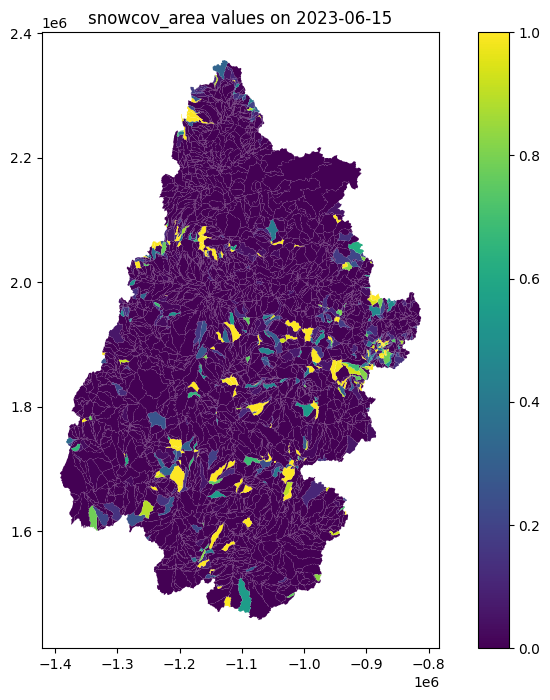

In [33]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Step 1. Open the netCDF file and select a time ---
# Replace 'your_file.nc' with your netCDF file path
nc_file = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/master_output/2023_daily_output.nc"
# nc_file = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/output/20250127_daily_output.nc"
ds = xr.open_dataset(nc_file)

# Specify the desired time (this can be a string or a datetime object)
# For example, let's use '2025-02-10'
selected_time = pd.to_datetime("2023-06-15")

# Select the tmax values at the given time. This assumes the time coordinate is decoded.
snowcov_area_at_time = ds.snowcov_area.sel(time=selected_time)

# --- Step 2. Convert the xarray DataArray to a DataFrame ---
# The DataArray should have coordinate 'nhru' (the IDs)
df_snowcov_area = snowcov_area_at_time.to_dataframe(name="snowcov_area").reset_index()
# Now df_snowcov_area will have columns: 'nhru' and 'snowcov_area'

# --- Step 3. Merge with the GeoDataFrame ---
# Assume you already have your GeoDataFrame loaded (e.g., from a shapefile)
# For example:
#gdf = gpd.read_file("your_polygons.shp")
# and it contains a column 'nhm_id' that maps to the netCDF 'nhru' IDs.
# For this example, we'll assume gdf is already available.

# Merge based on the matching IDs. Adjust key names if necessary.
gdf_merged = gdf.merge(df_snowcov_area, left_on='nhm_id', right_on='hruid', how='left')

# --- Step 4. Plot the result ---
fig, ax = plt.subplots(figsize=(10, 8))
gdf_merged.plot(column='snowcov_area', cmap='viridis', legend=True, ax=ax)
ax.set_title(f"snowcov_area values on {selected_time.strftime('%Y-%m-%d')}")
plt.show()

# Close the dataset when finished
ds.close()


In [18]:
gdf_merged

,nhm_id,model_hru_,geometry,hruid,time,tmaxf
0,83301,274,"POLYGON ((-1324125.133 1609094.887, -1324275.0...",83301,2023-02-10,37.918301
1,83302,275,"POLYGON ((-1331914.568 1623225.112, -1331901.0...",83302,2023-02-10,39.843399
2,83359,332,"POLYGON ((-1308375.036 1622938.630, -1308465.2...",83359,2023-02-10,41.229198
3,83364,337,"POLYGON ((-1337655.210 1640205.133, -1337535.3...",83364,2023-02-10,37.837502
4,83366,339,"POLYGON ((-1339634.862 1640985.080, -1339695.0...",83366,2023-02-10,36.434601
...,...,...,...,...,...,...
3846,86611,3556,"POLYGON ((-1256384.842 2032365.123, -1256295.1...",86611,2023-02-10,21.395399
3847,86615,3560,"POLYGON ((-1255034.951 2041934.777, -1255154.7...",86615,2023-02-10,40.886700
3848,86686,3631,"POLYGON ((-1244805.129 1970954.938, -1244744.9...",86686,2023-02-10,33.396702
3849,86691,3636,"POLYGON ((-1255664.885 1971375.143, -1255544.7...",86691,2023-02-10,28.606300


In [21]:
ds = xr.open_dataset("../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/input/2023-01-01_filled_converted.nc")
ds

<xarray.Dataset> Size: 164MB
Dimensions:   (time: 758, nhru: 3851)
Coordinates:
  * time      (time) datetime64[ns] 6kB 2023-01-01 2023-01-02 ... 2025-01-27
  * nhru      (nhru) int64 31kB 83028 83029 83030 83031 ... 86904 86905 86906
    lat       (nhru) float64 31kB ...
    lon       (nhru) float64 31kB ...
Data variables:
    tmax      (time, nhru) float64 23MB ...
    crs       float64 8B ...
    tmin      (time, nhru) float64 23MB ...
    prcp      (time, nhru) float64 23MB ...
    rhmax     (time, nhru) float64 23MB ...
    rhmin     (time, nhru) float64 23MB ...
    ws        (time, nhru) float64 23MB ...
    humidity  (time, nhru) float64 23MB ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:      2025_01_29_13_25_05 Original fileccreated  by gdptools pack...

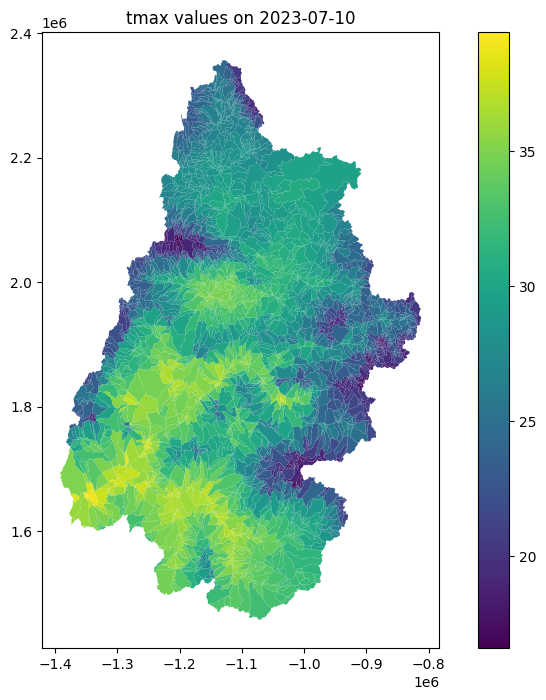

In [24]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Step 1. Open the netCDF file and select a time ---
# Replace 'your_file.nc' with your netCDF file path
nc_file = "../../../nhm-bind/NHM_PRMS_UC_GF_1_1/daily/input/2023-01-01_filled_converted.nc"
ds = xr.open_dataset(nc_file)

# Specify the desired time (this can be a string or a datetime object)
# For example, let's use '2025-02-10'
selected_time = pd.to_datetime("2023-07-10")

# Select the tmax values at the given time. This assumes the time coordinate is decoded.
tmax_at_time = ds.tmax.sel(time=selected_time)

# --- Step 2. Convert the xarray DataArray to a DataFrame ---
# The DataArray should have coordinate 'nhru' (the IDs)
df_tmax = tmax_at_time.to_dataframe(name="tmax").reset_index()
# Now df_tmax will have columns: 'nhru' and 'tmax'

# --- Step 3. Merge with the GeoDataFrame ---
# Assume you already have your GeoDataFrame loaded (e.g., from a shapefile)
# For example:
#gdf = gpd.read_file("your_polygons.shp")
# and it contains a column 'nhm_id' that maps to the netCDF 'nhru' IDs.
# For this example, we'll assume gdf is already available.

# Merge based on the matching IDs. Adjust key names if necessary.
gdf_merged = gdf.merge(df_tmax, left_on='nhm_id', right_on='nhru', how='left')

# --- Step 4. Plot the result ---
fig, ax = plt.subplots(figsize=(10, 8))
gdf_merged.plot(column='tmax', cmap='viridis', legend=True, ax=ax)
ax.set_title(f"tmax values on {selected_time.strftime('%Y-%m-%d')}")
plt.show()

# Close the dataset when finished
ds.close()
